# [book](https://nbviewer.org/github/fastai/fastbook/blob/master/13_convolutions.ipynb)

In [4]:
dependencies = [
    "kagtool",
    "kaggle",
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

In [81]:
import gc

from fastai.imports import *
import torch
from fastai.vision.all import *

import matplotlib.pyplot as plt

matplotlib.rc('image', cmap='Greys')

# Convolutions 101

In [82]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [83]:
path = untar_data(URLs.MNIST_SAMPLE)

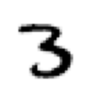

In [84]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [85]:
im3.shape

(28, 28)

In [86]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [87]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [88]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [89]:
im3_t[4:7,6:9] * top_edge

tensor([[ -0.,  -0.,  -0.],
        [  0.,   0.,   0.],
        [254., 254., 254.]])

In [90]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [91]:
# There's a right edge at cell 8,18. What does that give us?:
im3_t[7:10,17:20] * top_edge

tensor([[-254.,  -75.,   -0.],
        [   0.,    0.,    0.],
        [ 247.,   53.,    0.]])

In [92]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [93]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [94]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [95]:
try:
    apply_kernel(0,0,top_edge)
except Exception as e:
    print(e)

The size of tensor a (0) must match the size of tensor b (3) at non-singleton dimension 1


In [96]:
apply_kernel(1,1,top_edge)

tensor(0.)

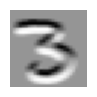

In [97]:
# apply top-edge kernel to whole image
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

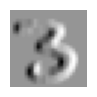

In [98]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

In [99]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape, edge_kernels

(torch.Size([4, 3, 3]),
 tensor([[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],
 
         [[-1., -1., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  1.,  1.]],
 
         [[ 0., -1.,  1.],
          [-1.,  1.,  0.],
          [ 1.,  0.,  0.]],
 
         [[ 1., -1.,  0.],
          [ 0.,  1., -1.],
          [ 0.,  0.,  1.]]]))

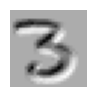

In [100]:
edge = tensor([[apply_kernel(i,j,edge_kernels) for j in rng] for i in rng])
show_image(edge);

# Let's Work On The Training Data Now

In [101]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [26]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [27]:
right_edge = tensor([[1, 0, -1],
                    [ 1, 0, -1],
                    [ 1, 0, -1]]).float()

vertical_edges = torch.stack([top_edge, right_edge])
vertical_edges.shape

torch.Size([2, 3, 3])

In [28]:
batch_features = F.conv2d(xb, vertical_edges.unsqueeze(1), padding=1)
batch_features.shape

torch.Size([64, 2, 28, 28])

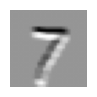

In [29]:
# looking at example 64
show_image(batch_features[63,0]);

# Neural Net To Recognize If It's a 7 or not

In [61]:
input_pixels = 28*28
hidden_size = 30
simple_net = nn.Sequential(
    nn.Linear(input_pixels,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

# CNN To Recognize If It's a 7 or not

In [62]:
input_size = 1
broken_cnn = sequential(
    nn.Conv2d(input_size,hidden_size, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(hidden_size,1, kernel_size=3, padding=1)
)
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### From 784 pixels to input size = 1?

### How To Go From Convolutions Layers To Classification Activation?

In [48]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

- that's not something we can use to do classification, we didn't compress any information from the input to the output
- we need a single ouput activation per image, not a 28x28 map of activations

- we need every convolutions to reduce the dimensions
- we need to use enough stride-2 convolutions so that the final layer size is 1

In [65]:
def conv(inputs_channels, output_channels, kernel_size=3, act=True):
    res = nn.Conv2d(inputs_channels, output_channels, stride=2, kernel_size=kernel_size, padding=kernel_size//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [66]:
simple_cnn = sequential(
    conv(1 ,4),            # *2     activation map size = 14x14
    conv(4 ,8),            # *2     activation map size = 7x7
    conv(8 ,16),           # *2     activation map size = 4x4
    conv(16,32),           # *2     activation map size = 2x2
    conv(32,1, act=False), # we need to recognize if it's a 7 or not
    Flatten(),
)
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [67]:
simple_cnn(xb).shape

torch.Size([64, 1])

In [68]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [69]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,0.495584,00:10
1,0.000000,0.000000,0.495584,00:08


In [70]:
# Understanding Convolution Arithmetic

In [71]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [60]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

# Receiptive Fields

# Recognize All 10 Digits

In [73]:
path = untar_data(URLs.MNIST)

In [74]:
Path.BASE_PATH = path

In [75]:
path.ls()

(#3) [Path('.DS_Store'),Path('training'),Path('testing')]

In [76]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

In [77]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

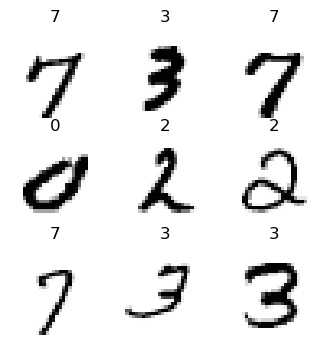

In [78]:
dls.show_batch(max_n=9, figsize=(4,4))

In [102]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [103]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

# 1 Cycle Training

In [104]:
from fastai.callback.hook import *

In [113]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [114]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.713204,0.693857,0.504416,00:09


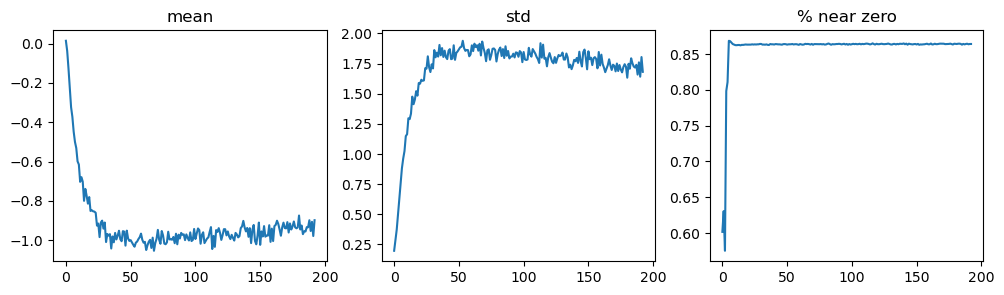

In [115]:
learn.activation_stats.plot_layer_stats(0)

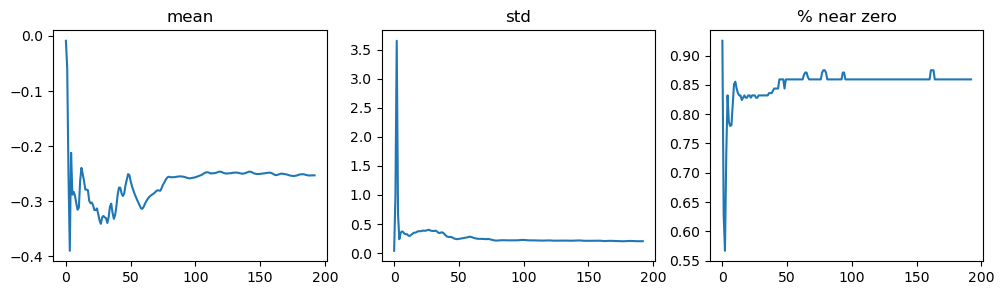

In [116]:
learn.activation_stats.plot_layer_stats(-2)

In [117]:
def fit_one_cycle(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn
learn = fit_one_cycle()

epoch,train_loss,valid_loss,accuracy,time
0,0.059675,0.029038,0.991168,00:08


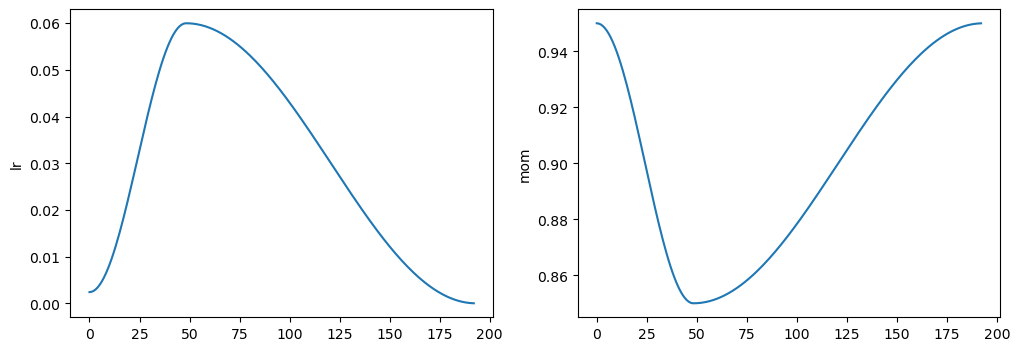

In [120]:
learn.recorder.plot_sched()

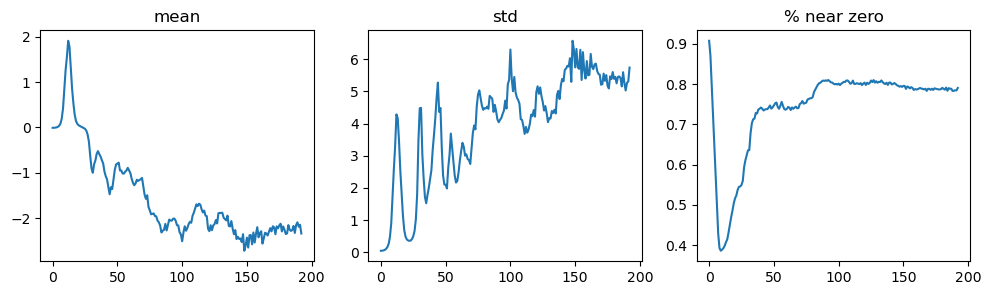

In [121]:
learn.activation_stats.plot_layer_stats(-2)

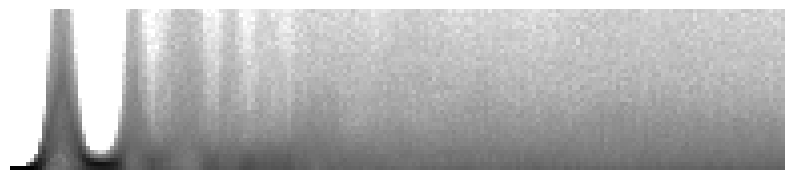

In [125]:
learn.activation_stats.color_dim(-2)

# BatchNorm

In [127]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [129]:
learn = fit_one_cycle()

epoch,train_loss,valid_loss,accuracy,time
0,0.074640,0.031428,0.996075,00:11


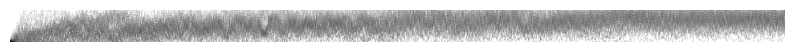

In [138]:
learn.activation_stats.color_dim(-2)

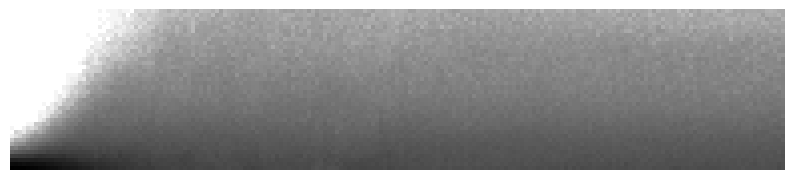

In [130]:
learn.activation_stats.color_dim(-4)

In [131]:
learn = fit_one_cycle(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.132635,0.032047,0.994603,00:12
1,0.024963,0.029659,0.993131,00:13
2,0.017522,0.016292,0.995093,00:12
3,0.008110,0.010125,0.997547,00:12
4,0.002722,0.006954,0.998528,00:11


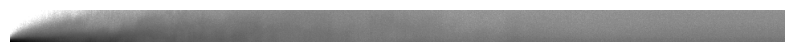

In [137]:
learn.activation_stats.color_dim(-4)